# Section 7

In [1]:
using PyPlot

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")

rcParams["text.usetex"] = true
rcParams["font.family"] = "serif"
rcParams["font.size"] = 16
rcParams["text.latex.preamble"] = raw"\usepackage{amsmath}"

"\\usepackage{amsmath}"

In [ ]:
import PyCall: pyimport
irbasis3 = pyimport("irbasis3")

PyObject <module 'irbasis3' from '/usr/local/opt/python@3.9/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/irbasis3/__init__.py'>

## Generate IR basis by singular value expansion

In [ ]:
# Create kenerl for lambda_ = 100 and beta = 10
# The default value of eps ``cutoff for singular values" is
# set to 2.2e-16.
# In this sample, we compute fewer basis functions.
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics="F", beta=beta, eps=1e-10)

PyObject <irbasis3.basis.FiniteTempBasis object at 0x18395feb0>

## Fitting $\rho(\omega)$

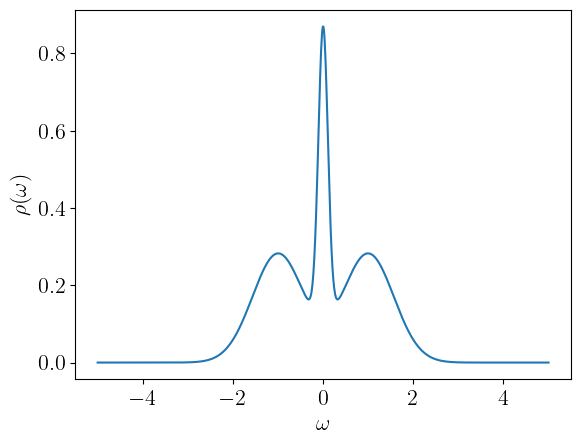

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/hiroshi/.julia/packages/PyCall/BD546/src/numpy.jl:67


1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x196c226d0>

In [ ]:
# Three Gaussian peaks (normalized to 1)
gaussian(x, mu, sigma) = exp.(-((x.-mu)/sigma).^2)/(sqrt(π)*sigma)

rho(omega) = 0.2*gaussian(omega, 0.0, 0.15) + 
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = collect(range(-5, 5, length=1000))
plt.xlabel(L"$\omega$")
plt.ylabel(L"$\rho(\omega)$")
plt.plot(omegas, rho(omegas))

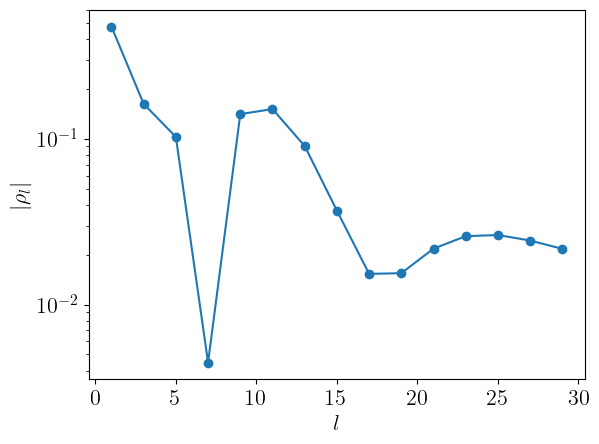

PyObject Text(32.13920022139201, 0.5, '$|\\rho_l|$')

In [ ]:
rhol = basis.v.overlap(rho)
plt.semilogy(1:2:length(basis.s), abs.(rhol[1:2:end]), marker="o")
plt.xlabel(L"$l$")
plt.ylabel(L"$|\rho_l|$")

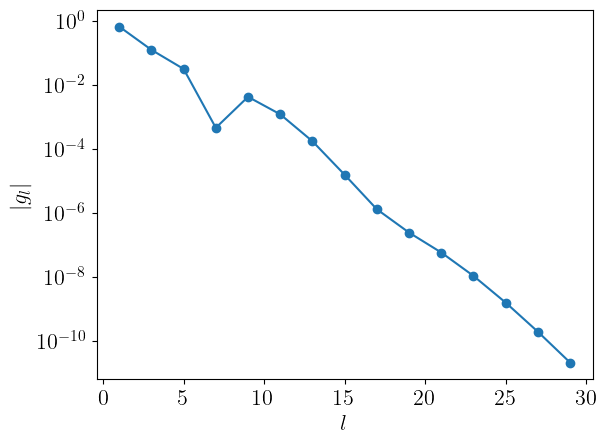

PyObject Text(32.139200221392, 0.5, '$|g_l|$')

In [ ]:
gl = -basis.s .* rhol
plt.semilogy(1:2:length(basis.s), abs.(gl[1:2:end]), marker="o")
plt.xlabel(L"$l$")
plt.ylabel(L"$|g_l|$")

## From IR to $\tau$

In [ ]:
function eval_gtau(taus)
    uval = basis.u(taus)
    return transpose(uval) * gl
end

eval_gtau (generic function with 1 method)

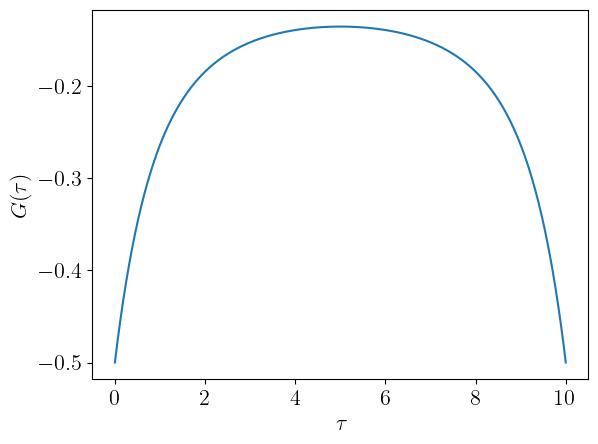

PyObject Text(32.13920022139201, 0.5, '$G(\\tau)$')

In [ ]:
taus = collect(range(0, beta, length=1000))
uval = basis.u(taus)
gtaus = transpose(uval) * gl
plt.plot(taus, gtaus)
plt.xlabel(L"$\tau$")
plt.ylabel(L"$G(\tau)$")

## Reconstruct $g_l$ by numerical integration

$$
g_l = \int_0^\beta d\tau U_l(\tau) G(\tau)
$$

In [ ]:
gl_reconst = basis.u.overlap(eval_gtau)

30-element Vector{Float64}:
 -0.6920636785862
  4.889751797909625e-17
  0.12981384456200573
  5.9631119486702744e-18
  0.03278400482491745
 -2.42861286636753e-17
  0.0004749125996026186
 -5.551115123125783e-17
 -0.004408753068411973
 -2.2985086056692694e-17
  0.0012537233549279455
  7.26415455565288e-18
 -0.00018077145487152232
  ⋮
  2.523468068481695e-7
 -5.312590645178972e-18
 -6.023717433992389e-8
 -1.1492543028346347e-17
  1.1190884872643372e-8
 -1.235990476633475e-17
 -1.6360664377088052e-9
 -2.5153490401663703e-17
  2.011088060405869e-10
 -3.0357660829594124e-18
 -2.192358934097107e-11
  4.4858864886587746e-18

## Reconstruct $g_l$ by sparse sampling (fitting)

In [ ]:
smpl = irbasis3.TauSampling(basis)
println("Sampling points: ", smpl.sampling_points)
println("Condition number: ", smpl.cond)
gl_reconst_sparse = smpl.fit(eval_gtau(smpl.sampling_points))

Sampling points: [0.012540375107178717, 0.025080750214357433, 0.084608404998333, 0.1796989521454872, 0.31247002491447273, 0.4859594077678564, 0.7042195121898956, 0.9723734269125226, 1.2965285468854475, 1.6833693532706349, 2.1391650644480844, 2.6679119879113684, 3.268556407887193, 3.931899929356174, 4.638747103136412, 5.361252896863588, 6.068100070643824, 6.731443592112809, 7.332088012088631, 7.860834935551916, 8.316630646729367, 8.703471453114553, 9.027626573087478, 9.295780487810104, 9.514040592232144, 9.687529975085527, 9.820301047854514, 9.915391595001667, 9.974919249785641, 9.987459624892821]
Condition number: 5.897702173686458


30-element Vector{Float64}:
 -0.6920636785862008
  9.542586906317466e-17
  0.1298138445620056
  7.24766863108653e-17
  0.03278400482491761
  2.9924814135574623e-17
  0.00047491259960302096
  2.3165241856424997e-17
 -0.004408753068411694
  5.77193712747442e-17
  0.0012537233549280227
  4.054120539075618e-17
 -0.00018077145487160884
  ⋮
  2.5234680699204315e-7
  1.2975668263782284e-17
 -6.023717485925673e-8
  3.249954561089755e-17
  1.1190884455225536e-8
  2.3570756929231493e-17
 -1.6360667057235823e-9
  1.440488002897832e-17
  2.0110906516490612e-10
 -4.6577829160370724e-18
 -2.1923221051045605e-11
 -1.1183244570001108e-17

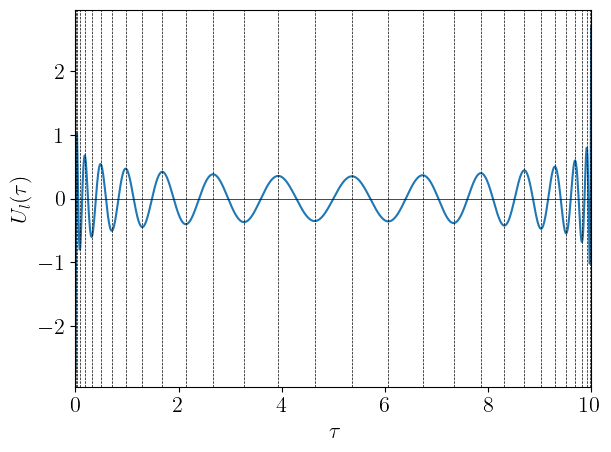

In [ ]:
dim = basis.size
plt.plot(taus, basis.u[dim](taus))
plt.plot(taus, zero(taus), ls="-", color="k", marker="", lw=0.5)
for x in smpl.sampling_points
    plt.axvline(x=x, ls="--", lw=0.5, color="k")
end
plt.xlabel(L"$\tau$")
plt.ylabel(L"$U_l(\tau)$")
plt.xlim([0, beta])
plt.tight_layout()
plt.savefig("sampling_points_tau_julia.pdf")

## Comparison

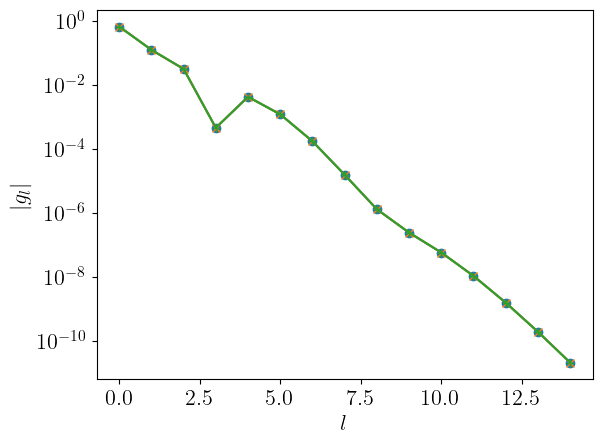

PyObject Text(32.139200221392, 0.5, '$|g_l|$')

In [ ]:
gl = -basis.s .* rhol
plt.semilogy(abs.(gl[1:2:end]), marker="o")
plt.semilogy(abs.(gl_reconst[1:2:end]), marker="x")
plt.semilogy(abs.(gl_reconst_sparse[1:2:end]), marker="+")
plt.xlabel(L"$l$")
plt.ylabel(L"$|g_l|$")

## Sparse sampling in Matsubara

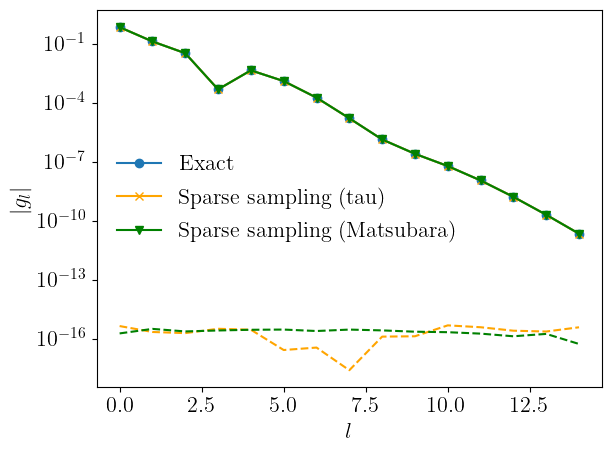

Sampling frequencies: [-229, -217, -93, -55, -39, -29, -23, -17, -15, -13, -11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11, 13, 15, 17, 23, 29, 39, 55, 93, 219, 229]
Condition number: 11.263335632185683


In [ ]:
function eval_giv(v)
    uhat_val = basis.uhat(v)
    return transpose(uhat_val) * gl
end

smpl_matsu = irbasis3.MatsubaraSampling(basis)
println("Sampling frequencies: ", smpl_matsu.sampling_points)
println("Condition number: ", smpl_matsu.cond)
gl_reconst_sparse_matsu = smpl_matsu.fit(eval_giv(smpl_matsu.sampling_points))

gl = -basis.s .* rhol
plt.semilogy(abs.(gl[1:2:end]), marker="o", label="Exact")
plt.semilogy(abs.(gl_reconst_sparse[1:2:end]), marker="x",
    label="Sparse sampling (tau)", color="orange")
plt.semilogy(abs.(gl_reconst_sparse_matsu[1:2:end]), marker="v",
    label="Sparse sampling (Matsubara)", color="green")
plt.semilogy(abs.(gl_reconst_sparse[1:2:end]-gl[1:2:end]), marker="", ls="--", label="",
    color="orange")
plt.semilogy(abs.(gl_reconst_sparse_matsu[1:2:end]-gl[1:2:end]), marker="", ls="--", label="",
    color="green")
plt.legend(loc="best", frameon=false)
plt.xlabel(L"$l$")
plt.ylabel(L"$|g_l|$")
plt.tight_layout()
plt.savefig("gl_sparse_julia.pdf")

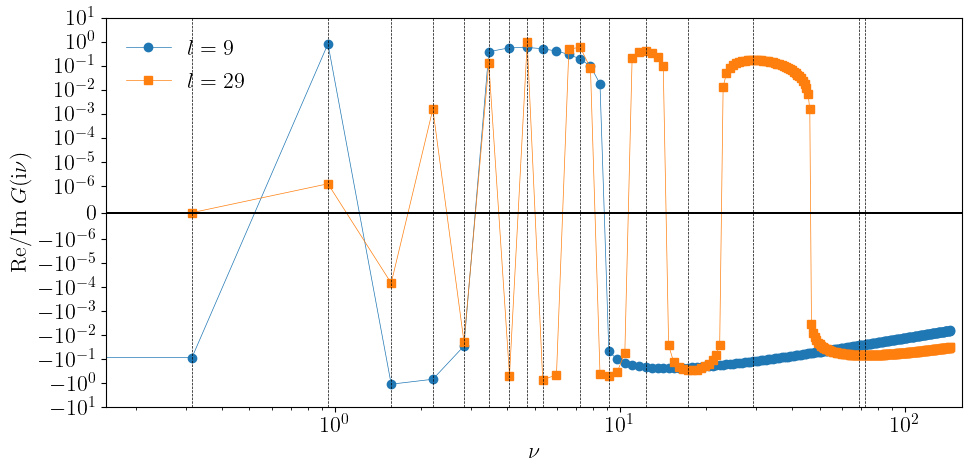

In [ ]:
get_nonzero_part(l, data) = l%2 == 0 ? imag(data) : real(data)

fig, ax = plt.subplots(figsize=(10,5))
    
nmax = 2*div(maximum(smpl_matsu.sampling_points),2)
nvec = 2*collect(-nmax:nmax) .+ 1
vvec = nvec .* (pi/beta)
markers = ["o", "s"]
for (idx_l, l) in enumerate([9, basis.size-1])
    ax.plot(vvec, get_nonzero_part(l, basis.uhat[l+1](nvec)), 
    label=L"$l=" * string(l) * L"$", ls="-", marker=markers[idx_l], ms=6, lw=0.5)
end

for n in smpl_matsu.sampling_points
    ax.axvline(n*pi/beta, ls="--", lw=0.5, color="k")
    ax.axhline(0, ls="-", lw=0.25, color="k")
end

ax.legend(frameon=false)
ax.set_xlabel(L"$\nu$")
ax.set_ylabel(L"Re/Im $G(\mathrm{i}\nu)$")
    
ax.set_xlim([0.5*pi/beta, nothing])
ax.set_ylim([-10, 10])
ax.set_xscale("log")
ax.set_yscale("symlog", linthresh=1e-6)
    
plt.tight_layout()
plt.savefig("uhat_julia.pdf")